In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
k = -1
b = 3 # y = kx + b => y = -x + 3 => y + x - 3 = 0
N_SAMPLES = 100
LOWER = -10.
UPPER = 10.

In [3]:
R = numpy.random.uniform(low=LOWER, high=UPPER, size=(N_SAMPLES, 2))
df = pandas.DataFrame(R, columns=['x', 'y'])
df.head()

,x,y
0,-2.982662,-0.514850
1,5.330339,-1.380899
2,-6.976826,7.510223
3,4.680230,5.911996
4,7.851922,0.017921


In [4]:
df = df.assign(c=-1)
df.head()

,x,y,c
0,-2.982662,-0.514850,-1
1,5.330339,-1.380899,-1
2,-6.976826,7.510223,-1
3,4.680230,5.911996,-1
4,7.851922,0.017921,-1


In [5]:
df.loc[df.y - k * df.x - b >= 0., 'c'] = 1
df[df.c == 1].head()

,x,y,c
1,5.330339,-1.380899,1
3,4.680230,5.911996,1
4,7.851922,0.017921,1
5,1.209076,3.359237,1
10,0.880653,6.985085,1


In [6]:
df[df.c == -1].head()

,x,y,c
0,-2.982662,-0.514850,-1
2,-6.976826,7.510223,-1
6,-3.074148,1.641159,-1
7,-8.969222,3.050023,-1
8,-5.634171,0.243757,-1


In [7]:
def plot_dataset(df, k, b):
    plt.scatter(df.x, df.y, c=df.c)
    x_all = numpy.arange(LOWER - 2., UPPER + 5.)
    plt.plot(x_all, k * x_all + b)

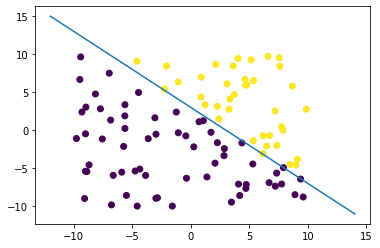

In [8]:
plot_dataset(df, k, b)

In [9]:
df.loc[:, 'x'] += numpy.random.normal(0., 1., size=N_SAMPLES)
df.loc[:, 'y'] += numpy.random.normal(0., 1., size=N_SAMPLES)

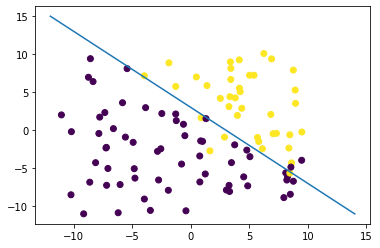

In [10]:
plot_dataset(df, k, b)

In [11]:
df[['x', 'y', 'c']].to_csv('points.csv', index=False)

In [12]:
from pyspark.sql import SparkSession

In [18]:
spark = SparkSession.builder.appName('Logistic-Regression').getOrCreate()
spark.sparkContext.setLogLevel('WARN')

In [20]:
data = spark.read.option("header", True).csv('points.csv').cache().rdd
data.take(10)

[Row(x='-2.569135342535734', y='-2.432942309100753', c='-1'),
 Row(x='1.625010063797573', y='-2.706017249999663', c='1'),
 Row(x='-5.450137889166188', y='8.112025825044093', c='-1'),
 Row(x='3.7871500979840604', y='4.257568235073122', c='1'),
 Row(x='8.451051434785406', y='-0.594913864549765', c='1'),
 Row(x='3.252461143682292', y='3.115556221752783', c='1'),
 Row(x='-2.482965293668939', y='2.204960822400191', c='-1'),
 Row(x='-7.78816657195814', y='1.7332554008380219', c='-1'),
 Row(x='-6.617827425024958', y='0.21528972601770352', c='-1'),
 Row(x='-10.207179226095475', y='-0.18583828484913556', c='-1')]

In [21]:
from pyspark.sql.types import Row

def process_row(row):
    d = row.asDict()
    
    x = float(d['x'])
    y = float(d['y'])
    d['features'] = numpy.array([x, y, 1.], dtype=float)
    del d['x']
    del d['y']
    d['c'] = int(d['c'])
    
    return Row(**d)

data = data.map(process_row).cache()
data.take(3)

[Row(c=-1, features=array([-2.56913534, -2.43294231,  1.        ])),
 Row(c=1, features=array([ 1.62501006, -2.70601725,  1.        ])),
 Row(c=-1, features=array([-5.45013789,  8.11202583,  1.        ]))]

In [22]:
w = numpy.random.normal(size=3)
w

array([ 0.42465616, -0.18858698, -0.01576142])

In [23]:
import math

def sigmoid(x):
    return 1. / (1. + math.exp(-x))

def grad_mapper(row):
    z = numpy.dot(w, row.features)
    return -row.features * row.c * sigmoid(-row.c * z)

N_POINTS = data.count()
N_ITERS = 100
ALPHA = 0.1
for i in range(N_ITERS):
    grads = data.map(grad_mapper)
    grad = grads.sum() / N_POINTS
    w -= ALPHA * grad

In [24]:
w # x * w[0] + y * w[1] + w[2] = 0 => y = (-w[0] / w[1]) * x + (-w[2] / w[1])

array([ 0.48968323,  0.59126135, -0.85886023])

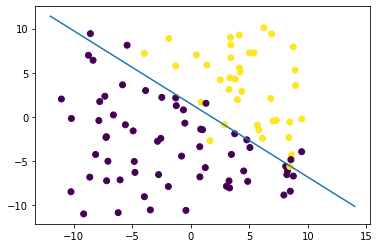

In [25]:
plot_dataset(df, k = -w[0] / w[1], b = -w[2] / w[1])